In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.integrate import solve_ivp
from sklearn.neighbors import NearestNeighbors 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from reservoir_computing.reservoir import Reservoir
from reservoir_computing.utils import make_forecasting_dataset
from tsa_course.lecture11 import computeLE, plot_bifurcation_diagram 
import scipy
np.random.seed(0)

In [20]:
# Define the Rössler attractor system of equations
def rossler_system(t, y, a, b, c):
    x, y, z = y
    dxdt = -y - z
    dydt = x + a*y
    dzdt = b + z*(x - c)
    return [dxdt, dydt, dzdt]

### Excercise 1

- Compute the bifurcation map of the Rössler system.
- Keep fixed the parameters $a = b = 0.2$
- Vary the parameter $c$ as shown below.
- For each value of $c$, compute and plot the local maxima of the time series $z(t)$ using the function `scipy.signal.find_peaks`. You should obtain a plot that resembles the figure below.
- Identify the first bifurcation point before the system becomes chaotic.
- Explain why computing the local maxima (peaks) was not necessary for the logistic map.

<img src="media/rossler_attractor.png" style="width: 100%; display: block; margin: auto;">

First, compute the jacobian of the rossler sistem.

  0%|          | 0/300 [00:00<?, ?it/s]

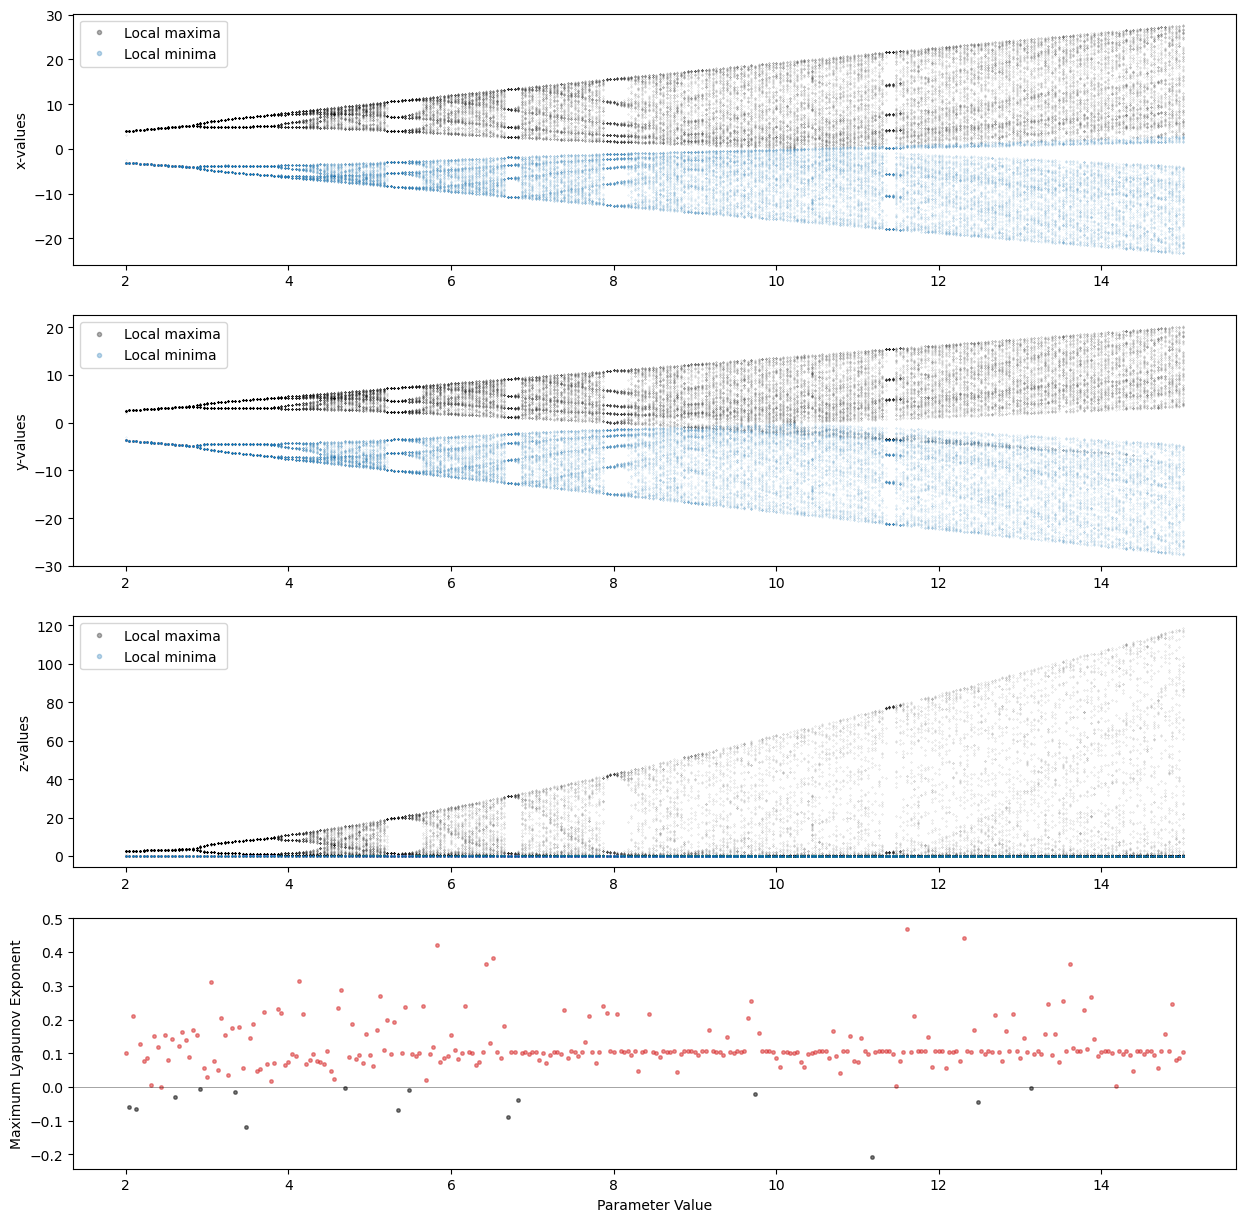

In [22]:

# Define jacobian 

def rossler_jac(t, y, a, b, c):
    x, y, z = y
    return np.array([[0, -1, -1],
                     [1, a, 0],
                     [z, 0, x - c]])

# Parameters
a, b= 0.2, 0.2
c_values = np.linspace(2, 15, 300) # value of c to explore

y0 = [0.0, 2.0, 0.0]  # Initial conditions
t = np.linspace(0, 500, int(5e4))

params = np.array([np.tile(a, len(c_values)),  np.tile(b, len(c_values)), c_values]).T


plot_bifurcation_diagram(func=rossler_system, func_jac=rossler_jac, 
                         x0=y0, time_vector=t, 
                         parameters=params, p_idx=2, max_time=500)



In [61]:
z_peaks = []
x_values = []
c_values = np.linspace(2, 15, 300) 
for c in c_values:

    solution = solve_ivp(rossler_system, [0, 500], y0, args=(a, b, c), dense_output=True)
    curr_peaks , _ = scipy.signal.find_peaks(solution.y[2])
    x_values.extend([c] * len(curr_peaks))
    z_peaks.extend(solution.y[2, curr_peaks])


Text(0.5, 1.0, 'Local maxima of z')

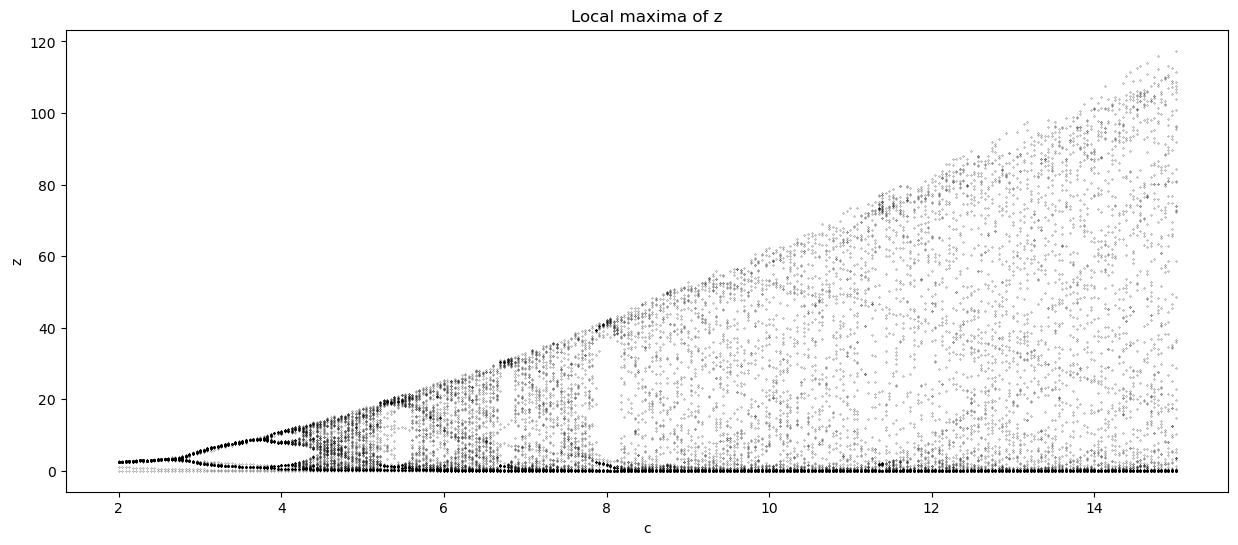

In [63]:
plt.figure(figsize=(15, 6))
plt.plot(x_values, z_peaks, 'ko', markersize=0.2, label="Local maxima")
plt.xlabel("c")
plt.ylabel("z")
plt.title("Local maxima of z")

plt.plot(x_values, )

The maps of local maxima is in "adaptation" of the bifurcation maps for multi dimensional systems. The logistic map system has only 1 variable, so it is possible to compute directly the discrete points where the system settles.


### Exercise 2

- Compute the (fractal) dimension of the object in the figure.

After the first split, the cube splits in 8 cubes on the front and back face + 2 in between, for a total of 8 pieces.
- R = 1, N = 1
- R = 2, N = 20

D = log(20)/log(2) = 4.32???


### Exercise 3

- Plot the Lorenz attractor for $\sigma = 10$, $\rho = 28$, and $\beta = \frac{8}{3}$.

In [65]:
def lorenz(t, x, sigma, rho, beta):
    res = np.zeros_like(x)
    res[0] = sigma*(x[1] - x[0])
    res[1] = x[0]*(rho - x[2]) - x[1]
    res[2] = x[0]*x[1] - beta*x[2]
    return res

def lorenz_jac(t, x,  sigma, rho, beta):
    res = np.zeros((x.shape[0], x.shape[0]))
    res[0,0], res[0,1] = -sigma, sigma
    res[1,0], res[1,1], res[1,2] = rho - x[2], -1., -x[0]
    res[2,0], res[2,1], res[2,2] = x[1], x[0], -beta
    return res

def plot_attractor(data, title="", interactive=False):
    xt, yt, zt = data[0], data[1], data[2]
    if interactive:
        fig = go.Figure(data=[go.Scatter3d(x=xt, y=yt, z=zt, mode='lines', line=dict(color='black', width=1))])
        fig.update_layout(title=title, scene=dict(xaxis_title='x(t)', yaxis_title='y(t)', zaxis_title='z(t)'),
                          autosize=False, width=800, height=600, margin=dict(l=0, r=0, b=0, t=0))
        fig.show()
    else:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(xt, yt, zt, linewidth=0.2, alpha=0.7, color='k')
        ax.set_title(title)
        plt.show()


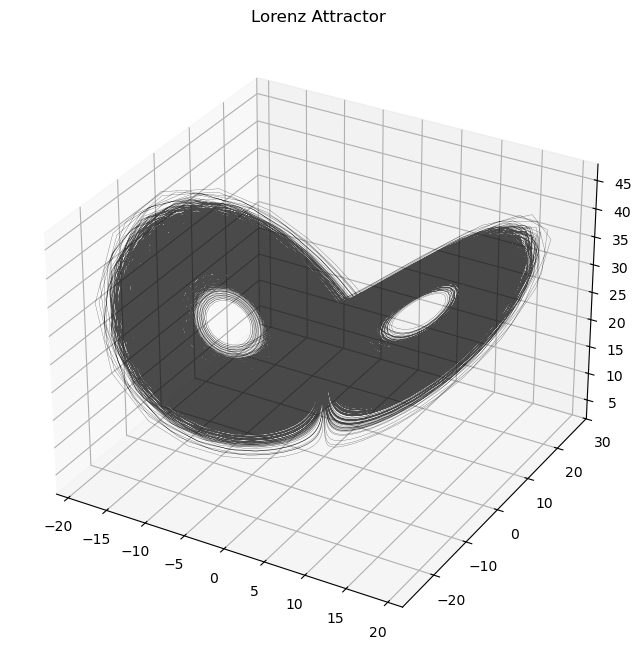

In [99]:
# Solve the differential equations
x0 = np.array([1.5, -1.5, 20.]) 
t = np.arange(0, 1000, 1e-2)
sigma, rho, beta = 10., 28., 8/3
p = (sigma, rho, beta)

solution = solve_ivp(lorenz, [0, 1500], x0, args=p, dense_output=True)
t = np.linspace(0, 1500, int(5e4))
lorenz_sol = solution.sol(t)

plot_attractor(lorenz_sol, title="Lorenz Attractor", interactive=False)

### Exercise 4

- Use the Taken's embedding to reconstruct the Lorenz attractor from the time series of its first state variable $x(t)$.
- Compute the optimal time delay $\tau$ and the optimal embedding dimension $m$ using the Mutual Information and the false Nearest-Neighbors algorithms.

In [75]:
def mutual_information(data, delay, n_bins):
    """
    Calculate the mutual information for a given delay using histograms.
    """
    # Prepare delayed data
    delayed_data = data[delay:]
    original_data = data[:-delay]
    
    # Compute histograms
    p_x, bin_edges = np.histogram(original_data, bins=n_bins, density=True)
    p_y, _ = np.histogram(delayed_data, bins=bin_edges, density=True)
    p_xy, _, _ = np.histogram2d(original_data, delayed_data, bins=bin_edges, density=True)
    
    # Calculate mutual information
    mutual_info = 0
    for i in range(n_bins):
        for j in range(n_bins):
            if p_xy[i, j] > 0 and p_x[i] > 0 and p_y[j] > 0:
                mutual_info += p_xy[i, j] * np.log(p_xy[i, j] / (p_x[i] * p_y[j]))
    
    return mutual_info

First, find the best delay tau that minimizes th emutual information in order to make shifted time series more indipendent with each others.

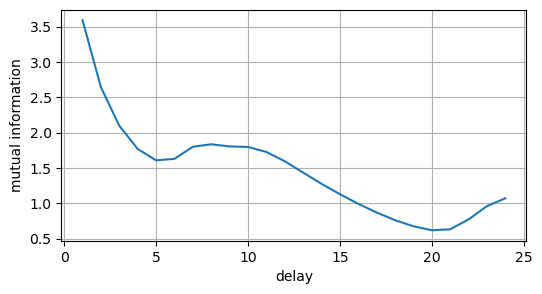

Minimum Mutual information for Lorenz attractor:  19


In [100]:
lorenz_ts = lorenz_sol[0]

MI = []
for i in range(1,25):
    MI = np.append(MI,[mutual_information(lorenz_ts,i,50)])
plt.figure(figsize=(6,3))
plt.plot(range(1,25), MI)
plt.xlabel('delay')
plt.ylabel('mutual information')
plt.grid()
plt.show()
print("Minimum Mutual information for Lorenz attractor: ", np.argmin(MI))

The optimal tau depends on the total time span and resolution. Using a step size of 500 returns an optimal tau of 15, with a step of 1500 the optimal tau is 19 instead.

Let's now find the optimal embedding dimension

In [101]:
def takens_embedding(data, delay, dimension):
    embedding = np.array([data[0:len(data)-delay*dimension]])
    for i in range(1, dimension):
        embedding = np.append(embedding, [data[i*delay:len(data) - delay*(dimension - i)]], axis=0)
    return embedding.transpose()

def calculate_fnn(data, delay, max_emb_dim, R_tol=10):
    fnn_proportions = []
    for m in range(1, max_emb_dim + 1):
        
        # Compute embeddings in m and m+1
        emb_m = takens_embedding(data, delay, m)
        emb_m_plus_one = takens_embedding(data, delay, m + 1)
        
        # Compute the nearest neighbors in m
        nbrs = NearestNeighbors(n_neighbors=2).fit(emb_m[:-delay])
        distances, indices = nbrs.kneighbors(emb_m[:-delay])

        n_false_nn = 0
        for i in range(0, len(distances)): 
            
            # Nearest neighbor of i in m and distance from it
            neighbor_index, R_m = indices[i, 1], distances[i, 1]
            
            # Dinstance in m+1 from the nearest neighbor in m
            R_m_plus_one = np.linalg.norm(emb_m_plus_one[i] - emb_m_plus_one[neighbor_index]) 

            # fNN formula
            if abs(R_m_plus_one - R_m) / R_m > R_tol:
                n_false_nn += 1
        
        fnn_proportion = n_false_nn / len(indices)
        fnn_proportions.append(fnn_proportion)
        
    return fnn_proportions

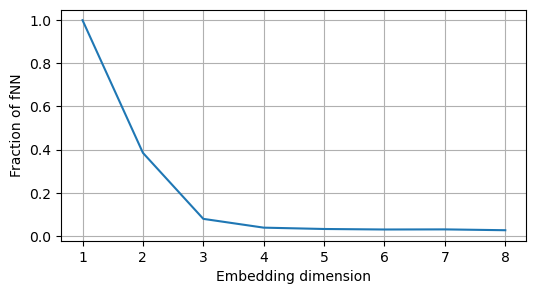

In [105]:
nFNN = calculate_fnn(lorenz_ts, delay=np.argmin(MI), max_emb_dim=8)

plt.figure(figsize=(6,3))
plt.plot(range(1,len(nFNN)+1),nFNN);
plt.xlabel('Embedding dimension')
plt.ylabel('Fraction of fNN')
plt.grid()
plt.show()

The number of false nearest neighbor decreases significantly and reaches a steady minimum at dimension m = 4

### Exercise 5

- Compute the predictions of the state variable $x(t)$ of the Lorenz system using the Taken's delay embeddings and a regression algorithm of your choice (Ridge Regression, Random Forest, etc...).

For this exercise, let's try XGBoost

MSE: 1.944


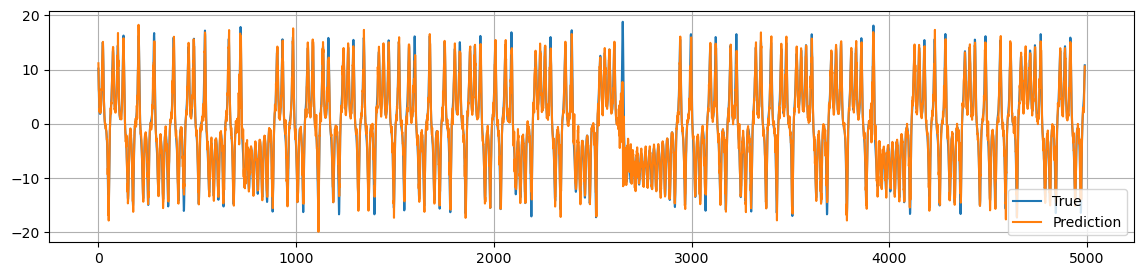

In [115]:
from xgboost.sklearn import XGBRegressor


def forecast_on_phase_space(y, delay, dimension, test_prop):
    
    # Compute embeddings
    emb = takens_embedding(y, delay=delay, dimension=dimension)
    
    # Create input and target
    X = emb[:, :-1]
    y = emb[:, -1]
    
    # Divide into train and test
    test_size = int(len(y)*test_prop)
    X_train = X[:-test_size, :]
    y_train = y[:-test_size]
    X_test = X[-test_size:, :]
    y_test = y[-test_size:]
    
    # Fit the regressor on the training data
    rf = XGBRegressor().fit(X_train, y_train)
    
    # Predict the test data
    preds = rf.predict(X_test)

    print(f'MSE: {mean_squared_error(y_test, preds):.3f}')
    plt.figure(figsize=(14,3))
    plt.plot(y_test, label='True')
    plt.plot(preds, label='Prediction')
    plt.grid()
    plt.legend()
    plt.show()

forecast_on_phase_space(lorenz_ts, delay=19, dimension=4+1, test_prop=0.1)

### Exercise 6

- Compute the predictions of the state variable $x(t)$ of the Lorenz system with an ESN using a forecast horizon of your choice.
- Make a 3D plot of the Reservoir states reduced to 3 dimensions with PCA and compare it to the actual Lorenz attractor.

Xtr shape: (44995, 2)
Ytr shape: (44995, 1)
Xte shape: (4995, 2)
Yte shape: (4995, 1)
states_tr shape: (1, 44985, 900)
states_te shape: (1, 4985, 900)
states_tr shape: (44985, 3)
states_te shape: (4985, 3)
MSE: 0.05


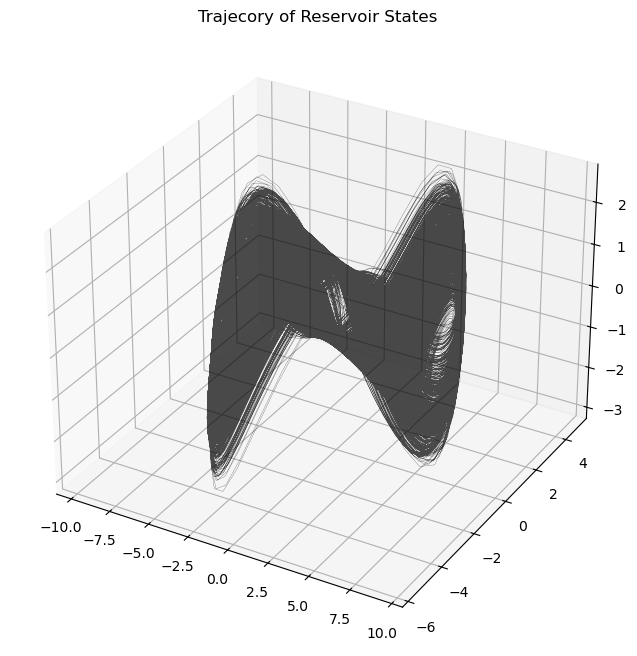

In [119]:
Xtr, Ytr, Xte, Yte, scaler = make_forecasting_dataset(lorenz_ts[:,None], 
                                                  horizon=5,
                                                  test_percent = 0.1)
print(f"Xtr shape: {Xtr.shape}\nYtr shape: {Ytr.shape}\nXte shape: {Xte.shape}\nYte shape: {Yte.shape}")

res= Reservoir(n_internal_units=900,
               spectral_radius=0.99,
               input_scaling=0.1,
               connectivity=0.25)

n_drop=10
states_tr = res.get_states(Xtr[None,:,:], n_drop=n_drop, bidir=False)
states_te = res.get_states(Xte[None,:,:], n_drop=n_drop, bidir=False)
print(f"states_tr shape: {states_tr.shape}\nstates_te shape: {states_te.shape}")

pca = PCA(n_components=3)
states_tr_pca = pca.fit_transform(states_tr[0])
states_te_pca = pca.transform(states_te[0])
print(f"states_tr shape: {states_tr_pca.shape}\nstates_te shape: {states_te_pca.shape}")

# Fit the regression model
rf = RandomForestRegressor().fit(states_tr_pca, Ytr[n_drop:,:].ravel())

# Compute the predictions
Yhat_pca = rf.predict(states_te_pca)[...,None]

# Compute the mean squared error
mse = mean_squared_error(scaler.inverse_transform(Yhat_pca), Yte[n_drop:,:])
print(f"MSE: {mse:.2f}")

plot_attractor(states_tr_pca.T, title="Trajecory of Reservoir States", interactive=False)